In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def load_train_valid_sets(data_dir='./data', valid_split=0.1, batch_size=128):
    
    transform = transforms.Compose(
        [
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize( 
                mean=[0.4914, 0.4822, 0.4465],
                std=[0.2023, 0.1994, 0.2010],
            )
        ]
    )
    
    trainset = torchvision.datasets.CIFAR10(root=data_dir, transform=transform, 
                                       train=True, download=True)
    
    
    train_size = int(len(trainset)*(1 - valid_split))
    valid_size = len(trainset) - train_size
    train, valid = torch.utils.data.random_split(trainset, [train_size, valid_size])
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size)
    
    classes = {k : trainset.classes[k] for k in range(len(trainset.classes))}
    
    return train_loader, valid_loader, classes

In [ ]:
def load_test_sets(data_dir='./data', batch_size=64):
    
    transform = transforms.Compose(
        [
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize( 
                mean=[0.4914, 0.4822, 0.4465],
                std=[0.2023, 0.1994, 0.2010],
            )
        ]
    )
    
    testset = torchvision.datasets.CIFAR10(root=data_dir, transform=transform, 
                                       train=False, download=True)
    
    
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

    return test_loader

Consists of 3 modules:

    - Module 1: Generate category independent region proposals which define the set of candidate detections available to detector.
    - Module 2: Large convolutional network that extracts fixed length feature vector from each region.
    - Module 3: Set of class specific linear SVMs.

## Module 1

In [6]:
import cv2

In [13]:
def selective_search(image):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    
    return ss.process()

In [14]:
test_image = cv2.imread('data/object_detection_test.jpeg')

In [18]:
bounding_boxes = selective_search(test_image)

In [29]:
len(bounding_boxes)

13502

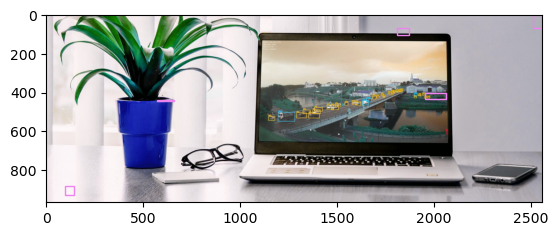

In [30]:
import matplotlib.pyplot as plt

plt.imshow(test_image)
for box in bounding_boxes[0:5]:
    rectangle = plt.Rectangle((box[0], box[1]), box[2], box[3], edgecolor='violet', alpha=1, facecolor='none')
    plt.gca().add_patch(rectangle)

In [95]:
def box_check(box_coords):
    
    assert(box_coords['x1'] < box_coords['x2'])
    assert(box_coords['y1'] < box_coords['y2'])

def calculate_iou(box1, box2):
    
    #get the intersection of the two boxes
    x_l = max(box1['x1'], box2['x1'])
    x_r = min(box1['x2'], box2['x2'])
    y_b = max(box1['y1'], box2['y1'])
    y_t = min(box1['y2'], box2['y2'])
    
    if (x_l > x_r) or (y_b > y_t):
        return None
   
    intersection_area = (x_r - x_l) * (y_t - y_b)
    area1 = box1['w'] * box1['h']
    area2 = box2['w'] * box2['h']
    
    iou = intersection_area / (area1 + area2 - intersection_area)
    
    return iou
    

In [99]:
box_a = {'x1' : 50, 'x2': 100, 'y1':10, 'y2': 100, 'w':50, 'h':90}
box_b = {'x1' : 250, 'x2': 300, 'y1':10, 'y2': 100}
box_c = {'x1' : 150, 'x2': 100, 'y1':10, 'y2': 100}
box_d = {'x1' : 75, 'x2': 120, 'y1':20, 'y2': 200, 'w':55, 'h':180}

In [100]:
box_check(box_a)

In [101]:
calculate_iou(box_a, box_d)

75
100
100
20


0.16129032258064516

In [94]:
25*80

2000